# **Capítulo 7: Convergencia y ajuste de modelos**

## Clasificación de imágenes usando la base de datos CIFAR10

Carga y preprocesado de datos

In [17]:
from tensorflow.keras.datasets import cifar10

# Cargamos los datos
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

# Normalizamos las imágenes
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

Visualización del aspecto de los datos

Tamaño del conjunto de entrenamiento: 50000
Tamaño del conjunto de test: 10000
Tamaño de las imágenes: (32, 32, 3)


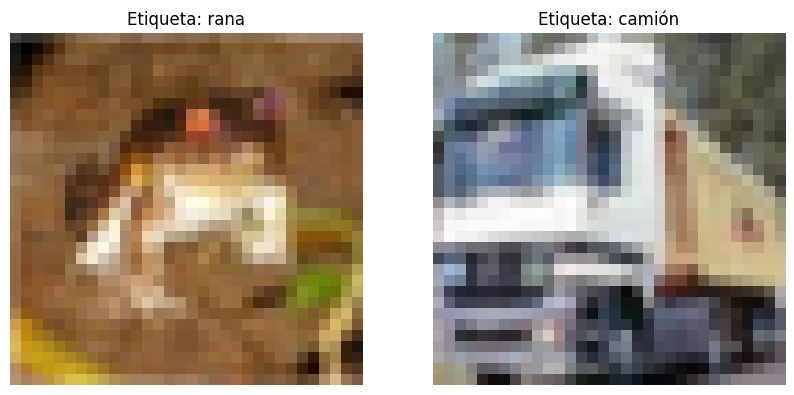

In [18]:
import matplotlib.pyplot as plt

# Dimensiones de los conjuntos de datos
print(f'Tamaño del conjunto de entrenamiento: {len(X_train)}')
print(f'Tamaño del conjunto de test: {len(X_test)}')
print(f'Tamaño de las imágenes: {X_train.shape[1:]}')

# Obtenemos dos imágenes del conjunto de entrenamiento para mostrarlas
imagenes, etiquetas = X_train[:2], Y_train[:2]

# Diccionario de etiquetas
clases = {0: 'avión', 1: 'coche', 2: 'pájaro', 3: 'gato', 4: 'ciervo',\
          5: 'perro', 6: 'rana', 7: 'caballo', 8: 'barco', 9: 'camión'}

# Visualizamos las imágenes y etiquetas de un batch de entrenamiento
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
for i in range(2):
    axs[i].imshow(imagenes[i])
    axs[i].set_title(f'Etiqueta: {clases[etiquetas[i].item()]}')
    axs[i].axis('off')
plt.show()

Creación de la CNN a usar

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

def crear_CNN(aumentos=None, normalizacion=False, dropout=0):
    entrada = Input(shape=(32, 32, 3))

    # Aumento de datos
    if aumentos:
        x = aumentos(entrada)
    else:
        x = entrada

    # 1) Bloque extractor de características
    # - Convolución con activación -> Normalización -> Pooling
    x = Conv2D(16, kernel_size=5, padding='same', activation='relu')(x)
    if normalizacion:
        x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2)(x)
    # - Convolución con activación -> Normalización -> Pooling
    x = Conv2D(32, kernel_size=5, padding='same', activation='relu')(x)
    if normalizacion:
        x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2)(x)
    # - Dropout
    x = Dropout(dropout)(x)

    # 2) Bloque clasificador de características
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    salida = Dense(10, activation='softmax')(x)

    return Model(inputs=entrada, outputs=salida)

Entrenamiento del caso base

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Caso base
modelo_base = crear_CNN()
modelo_base.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Model checkpoint
checkpoint = ModelCheckpoint(filepath='modelo_base.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=True,
                             verbose=1)

# Entrenamos el modelo base
historia_base = modelo_base.fit(X_train, Y_train,
                                validation_split=0.2,
                                epochs=50,
                                batch_size=256,
                                callbacks=[checkpoint])

Epoch 1/50
154/157 [============================>.] - ETA: 0s - loss: 1.7031 - accuracy: 0.3804
Epoch 1: val_accuracy improved from -inf to 0.48640, saving model to modelo_base.h5
157/157 [==============================] - 4s 13ms/step - loss: 1.6987 - accuracy: 0.3824 - val_loss: 1.4494 - val_accuracy: 0.4864
Epoch 2/50
153/157 [============================>.] - ETA: 0s - loss: 1.3668 - accuracy: 0.5068
Epoch 2: val_accuracy improved from 0.48640 to 0.54080, saving model to modelo_base.h5
157/157 [==============================] - 1s 9ms/step - loss: 1.3649 - accuracy: 0.5071 - val_loss: 1.2962 - val_accuracy: 0.5408
Epoch 3/50
152/157 [============================>.] - ETA: 0s - loss: 1.2103 - accuracy: 0.5696
Epoch 3: val_accuracy improved from 0.54080 to 0.58290, saving model to modelo_base.h5
157/157 [==============================] - 2s 11ms/step - loss: 1.2073 - accuracy: 0.5703 - val_loss: 1.1777 - val_accuracy: 0.5829
Epoch 4/50
152/157 [============================>.] - ETA: 

Definición y visualización de los aumentos empleados en el caso avanzado

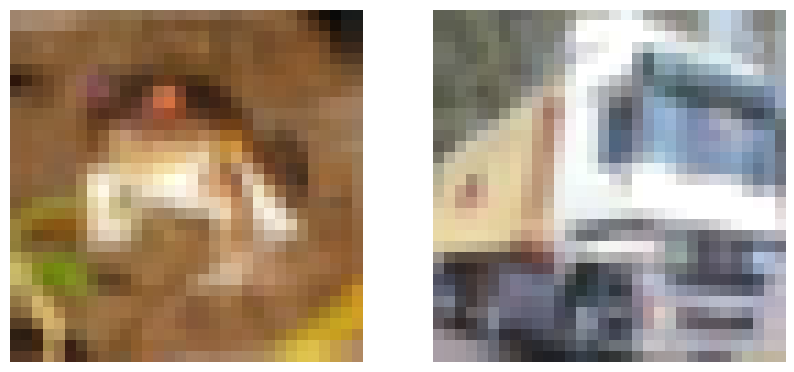

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation,\
    RandomBrightness

# Modelo de aumentos de datos
aumentos = Sequential()
aumentos.add(RandomRotation(0.05, fill_mode='nearest', input_shape=(32, 32, 3)))
aumentos.add(RandomFlip('horizontal'))
aumentos.add(RandomBrightness(0.1, value_range=(0, 1)))

# Visualizamos las imágenes aumentadas de un batch de entrenamiento
imagenes_aug = aumentos(imagenes)
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
for i in range(2):
    axs[i].imshow(imagenes_aug[i])
    axs[i].axis('off')
plt.show()

Entrenamiento del caso avanzado

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# Caso avanzado
modelo_avan = crear_CNN(aumentos=aumentos, normalizacion=True, dropout=0.5)
modelo_avan.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Model checkpoint
checkpoint = ModelCheckpoint(filepath='modelo_avan.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=True,
                             verbose=1)

# Early stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

# Entrenamos el modelo avanzado
historia_avan = modelo_avan.fit(X_train, Y_train,
                                validation_split=0.2,
                                epochs=50,
                                batch_size=256,
                                callbacks=[checkpoint, early_stop])

Epoch 1/50
155/157 [============================>.] - ETA: 0s - loss: 1.7364 - accuracy: 0.3856
Epoch 1: val_accuracy improved from -inf to 0.20410, saving model to modelo_avan.h5
157/157 [==============================] - 6s 19ms/step - loss: 1.7348 - accuracy: 0.3859 - val_loss: 2.9060 - val_accuracy: 0.2041
Epoch 2/50
157/157 [==============================] - ETA: 0s - loss: 1.4005 - accuracy: 0.4952
Epoch 2: val_accuracy improved from 0.20410 to 0.39750, saving model to modelo_avan.h5
157/157 [==============================] - 2s 15ms/step - loss: 1.4005 - accuracy: 0.4952 - val_loss: 1.7619 - val_accuracy: 0.3975
Epoch 3/50
154/157 [============================>.] - ETA: 0s - loss: 1.2734 - accuracy: 0.5462
Epoch 3: val_accuracy improved from 0.39750 to 0.52810, saving model to modelo_avan.h5
157/157 [==============================] - 2s 15ms/step - loss: 1.2725 - accuracy: 0.5464 - val_loss: 1.3940 - val_accuracy: 0.5281
Epoch 4/50
155/157 [============================>.] - ETA:

Comparación entre el caso base y el caso avanzado

Exactitud de test del modelo base: 68.04%
Exactitud de test del modelo avanzado: 75.38%


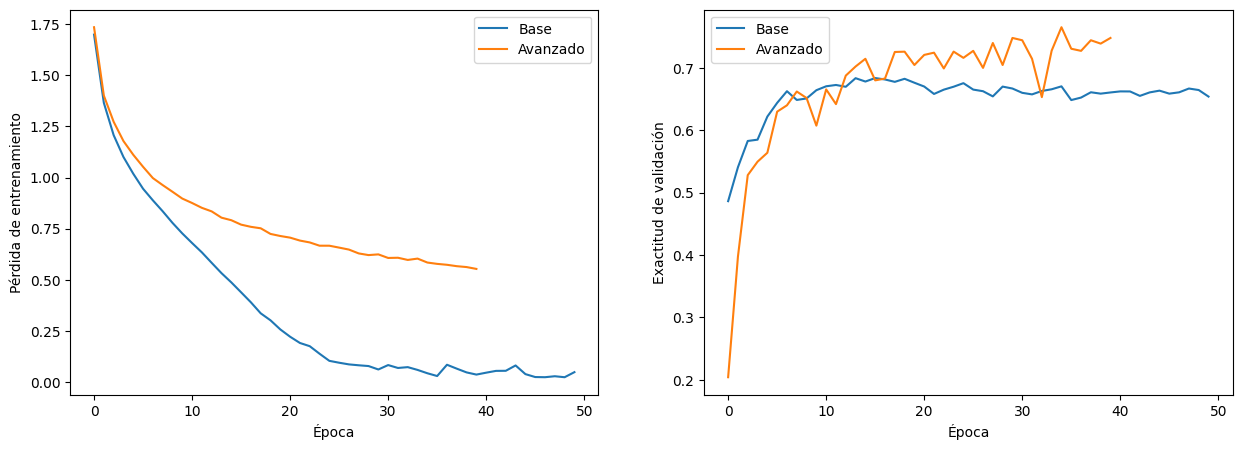

In [23]:
# Calcular la exactitud de test en función de la mejor exactitud de validación
# 1) Cargamos el mejor modelo
modelo_base.load_weights('modelo_base.h5')
modelo_avan.load_weights('modelo_avan.h5')
# 2) Evaluamos el modelo
test_base = modelo_base.evaluate(X_test, Y_test, verbose=0)
test_avan = modelo_avan.evaluate(X_test, Y_test, verbose=0)
print(f'Exactitud de test del modelo base: {test_base[-1]*100:.2f}%')
print(f'Exactitud de test del modelo avanzado: {test_avan[-1]*100:.2f}%')

# Visualizamos la perdida de entrenamiento y la exactitud de validación
# a lo largo de las épocas para ambos modelos
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
res_comp = {'Pérdida de entrenamiento': 'loss', 'Exactitud de validación': 'val_accuracy'}
for i, (k, v) in enumerate(res_comp.items()):
    axs[i].plot(historia_base.history[v], label='Base')
    axs[i].plot(historia_avan.history[v], label='Avanzado')
    axs[i].set_xlabel('Época')
    axs[i].set_ylabel(k)
    axs[i].legend()
plt.show()

Cálculo de la época de paso del modelo avanzado

In [24]:
import numpy as np

dif_epoca = np.argmax(historia_avan.history['val_accuracy'] > np.max(historia_base.history['val_accuracy']))
print(dif_epoca)

12
